# Mini-Lab 1: Logistic Regression and Support Vector Machines
## Animal Shelter Outcomes: A Classification Problem
### Alex Matsunami, RJ Smith, Cory Nichols


## Load Data from Project 1
Various transformations and explorations were performed in Project 1, and data saved to CSV as the conclusion of that project.

Here, we load in that data. For more information, please refer to the Project 1 notebook at https://github.com/pn1012/Data_Mining/blob/master/AnimalOutcomes/Project1_Exploration_Visualization_Dreduce.ipynb


In [5]:
import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from sklearn.preprocessing import LabelEncoder,StandardScaler,Imputer
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
df = pd.read_csv("Project1.csv")
print df.shape

(26728, 27)


# Mini-Lab Start : Logistic Regression and Support Vector Machines

Based on exploratory data analysis, some initial conclusions were made: we could easily see that fixing animals has a significant effect on their ability to be adopted, simply by visualizing the data and running basic statistical tests. 

However, we figured we were missing a few variables. In particular, the time of the outcome. Understanding when outcomes happen could be a critical component in understanding what optimal times or days our business partners should stay open or promote adoptive benefits heavily. 

Further, in order to answer the question more succintly, we have reduced our problem to a binary one: adopted or not. Given a binary outcome, there is roughly a 45/55 split on adopted and not adopted outcomes, respectively. 

A binary outcome will help to explain classification models more effectively and answer our business partner's question more directly: what variables are the most important for ADOPTION?


The first thing we need to do is get our data into algorithmic shape. We intend to use two methodologies to build a classification model predicting binary outcomes. These two methodologies are Logistic Regression and Support Vector Machines.

Given the linear separation dependency of Logistic Regression, we find it critical to attempt a non-linear classification algorithm with a Support Vector Machine. We will also fit a linear SVM to the data as well.

This should help us to not only fit a predictive model, but to also create a description for the answer to our the question: "How can we get more animals adopted?"

Let's go ahead and clean our data up. We have quite a few features left over, simply for visualization purposes.

In [3]:
df.head()

,Unnamed: 0,Name,DateTime,Outcome,Type,SexuponOutcome,AgeuponOutcome,Breed,Color,Has_Name,...,Is_Weekday,time_of_day,hour,age_range,dark,exotic,light,neutral,Outcome_Label,Primary_Color_Label
0,0,Hambone,2014-02-13 02:22:00,Return_to_owner,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,1,...,1,0,2,a_young,0.0,0.0,0.0,1.0,3,3
1,1,Emily,2013-10-13 19:44:00,Euthanasia,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,1,...,0,2,19,a_young,0.0,0.0,1.0,0.0,2,2
2,2,Pearce,2015-01-31 20:28:00,Adoption,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,1,...,0,2,20,b_adult,0.0,0.0,1.0,0.0,0,2
3,3,NaN,2014-07-12 02:09:00,Transfer,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,0,...,0,0,2,a_young,0.0,0.0,1.0,0.0,4,2
4,4,NaN,2013-11-15 20:52:00,Transfer,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,...,1,2,20,b_adult,0.0,0.0,0.0,1.0,4,3


We'll create a new dataframe called df_alg (for df_algorithm), and discretize our mostly categorical dataset. 

We've also included our new time features for good measure: time_of_day, is_weekday, and hour. These variables are ordinal, binary and continuous in nature, they do not require dummies and the range on hour is 24. 

In [7]:
classLabels = LabelEncoder()
for c in np.unique(df['Outcome']):
    print c, df.Outcome[df.Outcome == c].count()

# given such a low representation for died and euthanasia, it would be better to make this a binary outcome
# we will group all other values except adoption

# grab a new dataframe
df_alg = df[['Is_Fixed','Has_Name','Type','Is_Aggressive','Size','Is_Popular','Age_Value',
             'Gender','dark','exotic','light','neutral','Is_Weekday','time_of_day','hour','Outcome_Label']]

df_alg.loc[:,'Outcome_Label'] = df.loc[:,'Outcome'].apply(lambda x: 1 if x == 'Adoption' else 0)
df_alg.loc[:,'Is_Fixed'] = df.loc[:,'Is_Fixed'].apply(lambda x: 1 if x == 'Fixed' else 0)

# now let's line up the rest of our features to get ready for logistic regression and SVM
df_alg.loc[:,'Type'] = df.loc[:,'Type'].apply(lambda x: 1 if x == 'Dog' else 0)
df_alg.loc[:,'Gender'] = df.loc[:,'Gender'].apply(lambda x: 1 if x == 'Male' else 0)

#Using Age instead: df_alg.loc[:,'age_range'] = classLabels.fit_transform(df.loc[:,'age_range'])
df_alg.loc[:,'Size'] = classLabels.fit_transform(df.loc[:,'Size'])
df_alg.loc[:,'Age_Value'] = df.loc[:, 'Age_Value']
df_alg.loc[:, :] = df_alg.astype(np.int64)

print df_alg.shape
df_alg.describe()

Adoption 10769
Died 197
Euthanasia 1555
Return_to_owner 4785
Transfer 9422


C:\Anaconda2\lib\site-packages\pandas\core\indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(26728, 16)


,Is_Fixed,Has_Name,Type,Is_Aggressive,Size,Is_Popular,Age_Value,Gender,dark,exotic,light,neutral,Is_Weekday,time_of_day,hour,Outcome_Label
count,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000,26728.000000
mean,0.723661,0.712249,0.583433,0.162975,0.624626,0.188043,794.037227,0.524656,0.317532,0.099559,0.289547,0.293363,0.695825,1.144904,12.767996,0.402911
std,0.447195,0.452723,0.492999,0.369350,0.902864,0.390753,1082.374554,0.499401,0.465525,0.299416,0.453560,0.455312,0.460066,0.951823,9.471827,0.490492
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,365.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,18.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1095.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,2.000000,21.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,7300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,23.000000,1.000000


## LOGISTIC REGRESSION

Now that we have a binary outcome we're interested in, we'll go ahead and fit a logistic regression model to the full feature set we just created and perform model selection on the data. (this is assuming we don't create a validation set from our training data as we haven't gotten there yet on lesson plan). 

However, in order to test effectively and ensure class balances in each split, we will use StratifiedShuffleSplit from sklearn. 

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score, StratifiedShuffleSplit
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore")

scl = StandardScaler()
lr = LogisticRegression()
X_train = df_alg.values[:,:-1] # features
y_train = df_alg.values[:,-1] # target, binary

cv_object =  StratifiedShuffleSplit(y=y_train,
                                    n_iter=5,
                                    test_size=0.2)

Since we have included an hour feature, it would be best to scale our data. Hour's range is 24, while the second largest range is 3, for age_range. Thus we will standardize our data appropriately to represent weights correctly and help us choose which variables are the most important in our model. Unfortunately, we cannot reduce dimensionality in this case with standard methods like PCA and LDA because of such a categorical heavy dataset.

Let's take a quick look at our accuracy on 3 shuffles with standardized data using an out of the box logistic regression model:

In [6]:
accuracies = cross_val_score(lr, scl.fit_transform(X_train), y=y_train, cv=cv_object, verbose= 0) # this also can help with parallelism
print(accuracies)

[ 0.72502806  0.73812196  0.74186308  0.7476618   0.73924429]


Let's also check out our accuracy across penalty and cost parameters:

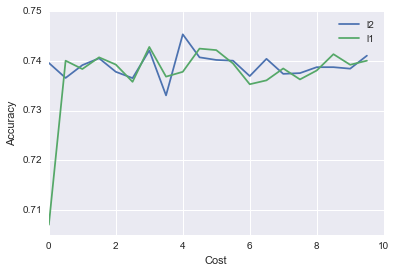

In [7]:
costs = np.arange(0.001,10,0.5)

l2s = []
l1s = []
for i in costs:
    for j in ['l1','l2']:
        lr2 = LogisticRegression(penalty = j, C = i)
        accuracies = np.average(cross_val_score(lr2, scl.fit_transform(X_train), y=y_train, cv=cv_object, verbose= 0))
        if j == 'l1':
            l1s.append(accuracies)
        else:
            l2s.append(accuracies)
# best accuracy @ cost of zero (max reg for logit) using l2 regularlization
plt.plot(costs, l2s)
plt.plot(costs, l1s)
plt.legend(['l2','l1'])
plt.ylabel('Accuracy')
plt.xlabel('Cost')
plt.show()

74% on our training set is not great, but it's better than random selection. That being said, we can definitely tune our model to understand how regularlization can help (or hinder) or classification accuracy. It looks as if L1 (LASSO) penalty is our optimal parameter setting for our training set. This will give us sparseness in our parameters, allowing us to simplify our model moreso than L2 (ridge). However, we need to first use our validation set to confirm our findings. 

First, let's take a look at our accuracy rate again, this time using five fold stratified cross validation and the number of observations in our data set. Let's look at our learning curve and the variability associated with our training and validation sets:

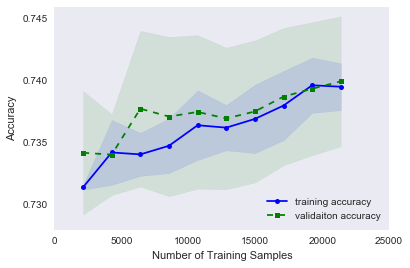

In [8]:
# playing with pipelines, adapted from Rauschka
from sklearn.learning_curve import learning_curve # uses stratified k fold by default

pipe_lr = Pipeline([('scl', StandardScaler()),('clf', LogisticRegression(penalty='l1'))]) # set up pipeline
                                                                                          # automatically scale
train_sizes, train_scores, valid_scores = learning_curve(estimator=pipe_lr, 
                                                         X = X_train, 
                                                         y = y_train, 
                                                         train_sizes = np.linspace(0.1, 1.0, 10) ,# spacing of samples, 
                                                         cv = 5, # 5 fold
                                                         n_jobs = -1) # use all processors
train_mean = np.mean(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.plot(train_sizes, train_mean, c='blue', marker='o',  markersize=5, label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, valid_mean, c='green', marker='s', linestyle='--',  markersize=5, label='validaiton accuracy')
plt.fill_between(train_sizes, valid_mean + valid_std, valid_mean - valid_std, alpha=0.1, color='green')
plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

What we can see is that we do not generalize well to our validation set in our training data when the number of samples is low -- we see high variance and overfitting. Validation lags behind training accuracy on average until about 21,000 samples. There is better generalization with a larger number of samples. As expected, the validation result does have a higher variance in this case, but in general, more samples benefits the accuracy of our model. 

Let's tune the critical hyperparameters of our Logistic Regression model: regularlization cost and penalty. We'll interactively test the parameters below and then visualize optimal cost and penalties for our dataset.

In [9]:
from ipywidgets import widgets as wd
from sklearn.metrics import roc_curve

def lr_explore(cost, penalty):
    lr = LogisticRegression(penalty=penalty, C=cost, class_weight=None) 
    accuracies = cross_val_score(lr, scl.fit_transform(X_train), y_train, cv=cv_object) 
    print 'Average Accuracy:', np.average(accuracies)
    
wd.interact(lr_explore, cost=(0.001,10.0,0.05), penalty =['l1','l2'])

Average Accuracy: 0.738421249532


<function __main__.lr_explore>

After confirming l1 penalty with a large amount of regularlization is optimal for fitting our model let's take a look directly at a visual of our regularlization parameter C:

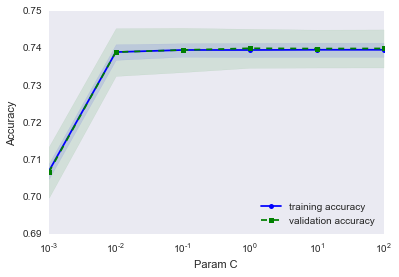

In [10]:
# take a look at C levels and associated accuracy on a stratified 5 fold CV
from sklearn.learning_curve import validation_curve

param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, valid_scores = validation_curve(
                                             estimator = pipe_lr,
                                             X = X_train,
                                             y = y_train,
                                             param_name = 'clf__C', # vary the C parameter directly
                                             param_range = param_range,
                                             cv = 5
                                             )
train_mean = np.mean(train_scores,axis=1)
train_std = np.std(train_scores,axis=1)
valid_mean = np.mean(valid_scores,axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5,label='training accuracy')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha = 0.1, color='blue')
plt.plot(param_range, valid_mean, color='green', marker='s', linestyle='--', markersize=5,label='validation accuracy')
plt.fill_between(param_range, valid_mean + valid_std, valid_mean - valid_std, alpha = 0.1, color='green')
plt.grid()
plt.xscale('log')
plt.legend(loc='lower right')
plt.xlabel('Param C')
plt.ylabel('Accuracy')
plt.show()

                                    

With a large amount of regularlization, we can see that our validation and training sets are almost identical. This indicates we are NOT overfitting our model with a significant C hyperparameter using LASSO (l1 penalty). Therefore, it's optimal we move forward with l1 and a significant regularlization. 

Note: sklearn's C parameter is an INVERSE regularlization parameter for logistic regression, the lower, the MORE regularlization in the model.

Now, let's repeat our 80/20 split on our training set using shuffles to see if we've improved based on our research.

In [11]:
lr_final = LogisticRegression(penalty='l1', C=0.001)
accuracies = cross_val_score(lr_final, scl.fit_transform(X_train), y_train, cv=cv_object) 
print np.average(accuracies)

0.709390198279


A very slight, however, an improvement! Now that we've performed model selection on our training set by dividing it into subtraining and validation sets, let's fit the entire training set and take a look at our coefficients.

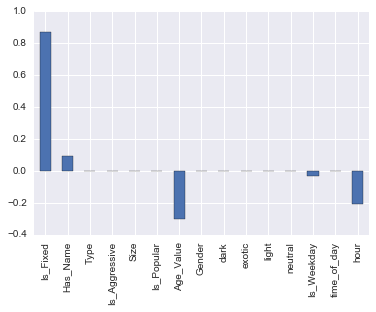

In [12]:
lr_final.fit(scl.fit_transform(X_train),y_train)
weights = pd.Series(lr_final.coef_[0], index=df_alg.columns[:-1])
weights.plot(kind='bar')
plt.show()
# LASSO results show we can eliminate pretty much everything outside of is_fixed and age_range (woot)

## Interpreting Logistic Regression Weights

Even though our model is only around 74% accurate on our validation dataset, we have obvious opportunities to simplify. The standardized data has resulted in a sparse coefficient array for our Logistic Regression model. This is one of the main benefits of utilizing a LASSO approach. 

Is_Fixed (0.91) is obviously the most important attribute in determining whether or not an animal is adopted. If an animal is fixed, it's more likely to be adopted. Age (-.36), as well, is quite important. The younger, the more likely to be adopted.

These variables, from experience and domain knowledge, were expected to be highly important. Spaying and neutering is cost prohibitive for some consumers, and the average adoptor is almost always interested in younger animals. Further, most owners do no want animals who are capable of reporoducing. Age is important because of potential health risks and maximum anticipated time with the animal. However, these assumptions are purely anecdotal and would need to be tested themselves. That being said, the ultimate conclusion given the result above is not surprising. 

What is interesting, however, is the lack of importance when it comes to size. This could be a result of the binarization process, in which size categories were created and may need to be revisited. 

The business result confirms our initial suspicions: fix the animals, name them and make them available on the weekend to maximize the chance of adoption. Our business partners cannot do anything about age.

The analytical result allows us to move forward with a two feature model, including age_range and Is_Fixed. 

In [13]:
X_reduced = df_alg[['Is_Fixed','Age_Value']].values
lr_reduced = LogisticRegression(penalty='l1', C=0.01)
lr_reduced.fit(X_reduced, y_train)
accuracies = cross_val_score(lr_final, scl.fit_transform(X_train), y_train, cv=cv_object)
print(np.average(accuracies))

0.706472128694


In [14]:
from  matplotlib.colors import ListedColormap # credit: Sebastian Rauschka: Python Machine Learning
def plot_decision_regions(X,y,classifier,test_idx=None,resolution=0.02):
    # set up marker generator and color map
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    # plot decision surface
    x1_min, x1_max = X[:,0].min() - 1, X[:,0].max() +1
    x2_min, x2_max = X[:,1].min() - 1, X[:,1].max() +1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1,xx2,Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    # plot all samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y==cl,0], y=X[y==cl,1],
                   alpha=0.8,c=cmap(idx),
                   marker=markers[idx],label=cl)
        
    # highlight test samples
    if test_idx:
        X_test, y_test = X[test_idx,:], y[test_idx]
        plt.scatter(X_test[:,0],X_test[:,1],c='',
                   alpha=1.0,linewidths=1,marker='o',
                   s=55,label='test set')

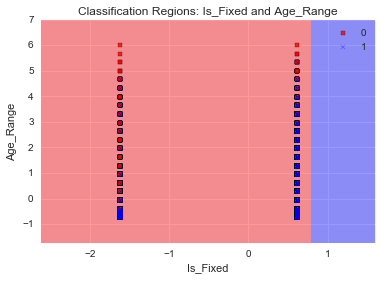

In [15]:
plot_decision_regions(scl.fit_transform(X_reduced), y_train, lr_reduced)
plt.xlabel('Is_Fixed')
plt.ylabel('Age_Range')
plt.title('Classification Regions: Is_Fixed and Age_Range')
plt.legend(loc='best')
plt.show()

Our decision regions visually show that fixed, young animals are adopted. While older animals have less of a chance to be adopted, even if they are fixed. 

We still maintain 74% accuracy, after reducing the amount of features in our dataset to only two.

## Logistic Regression Conclusion

74% accuracy is better than random chance, however, our classification model can likely be improved by gathering critical features, such as pre-existing medical conditions, if the animal has reproduced before and solidifying whether or not an animal truly is aggressive, instead of using arbitrary lists to identify aggressive breeds. We believe this would push our model accuracy over 80% and provide a more holistic conclusion on what factors drive adoption for our business partners.

## Support Vector Machine

Now let's take another route: support vector machines. We will fit both linear and non-linear support vector machines to the data and compare this methodology with logistic regression.

We will use sklearn's SVC Support Vector Machine classifier to train the model.

### Using SVM Linear Kernel
We will use linear support vector which should give similar results to logistic regression as we are classifying on a binary class outcome.

Running the training only once, with 80% of data for training, and 20% of data for testing.

In [31]:
# This will take some time. Use stochasitc gradient descent instead
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

scl = preprocessing.StandardScaler()

test_cases = int(len(df_alg.index) * 0.2)

x_train = df_alg.values[:-test_cases,:-1] # features
x_test = df_alg.values[-test_cases:,:-1] # features
y_train = df_alg.values[:-test_cases,-1] # target, binary
y_test = df_alg.values[-test_cases:,-1] # target, binary

model = SGDClassifier(loss='hinge', penalty='l2',n_jobs = -1, n_iter=1000)
model.fit(scl.fit_transform(x_train),y_train)

yhat = model.predict(scl.transform(x_test))
score = accuracy_score(yhat, y_test)

print("Accuracy: %s" % (score))

Accuracy: 0.740879326473


### Feature Weights
With Linear Kernel, we are able to leverage coefficients of the support vector to determine the relative weights of the explanatory variables. Here, we plot out the relative weights of each of the features used in training the model.

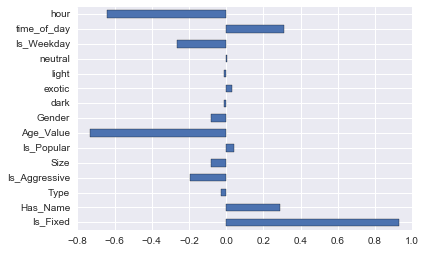

In [32]:
weights = pd.Series(model.coef_[0], index=df_alg.columns[:-1])
weights.plot(kind='barh')
plt.show()

### Using SVM RBF Kernel

Now, we will use the Radial Basis Function Kernel to seek improvement here on model accuracy over the strict linear kernel.

In [34]:
from sklearn import svm

model = svm.SVC(kernel = 'rbf')
model.fit(scl.fit_transform(x_train),y_train)

yhat = model.predict(scl.transform(x_test))
score = accuracy_score(yhat, y_test)

print("Accuracy: %s" % (score))


Accuracy: 0.7659494855


### Separate Models: Cats vs. Dogs
Rather than incorporating only as a feature in a single model, let's break up the datasets into cats and dogs and then build separate models and compare the accuracies of each.

In [36]:
# df.loc[:,'Type'].apply(lambda x: 1 if x == 'Dog' else 0)
dogs = df_alg[df_alg.Type == 1]
cats = df_alg[df_alg.Type == 0]

print np.shape(dogs) #11134
print np.shape(cats) #15594

(15594, 16)
(11134, 16)


### Dogs

Now, let's train RBF kernel SVM for Dogs only and determine the accuracy.

In [37]:
x = dogs.values[:,:-1] # features
y = dogs.values[:,-1] # target, binary

test_cases = int(len(dogs.index) * 0.2)

x_train = dogs.values[:-test_cases,:-1] # features
x_test = dogs.values[-test_cases:,:-1] # features
y_train = dogs.values[:-test_cases,-1] # target, binary
y_test = dogs.values[-test_cases:,-1] # target, binary

model = svm.SVC(kernel = 'rbf')
model.fit(scl.fit_transform(x_train),y_train)

yhat = model.predict(scl.transform(x_test))
score = accuracy_score(yhat, y_test)

print("Accuracy: %s" % (score))

Accuracy: 0.723540731238


The lower accuracy score for dogs indicates there is additional work here to bring the model to parity to that of cats.

### Cats

Now, let's train RBF kernel SVM for Cats only and determine the accuracy.

In [38]:
x = cats.values[:,:-1] # features
y = cats.values[:,-1] # target, binary

test_cases = int(len(dogs.index) * 0.2)

x_train = cats.values[:-test_cases,:-1] # features
x_test = cats.values[-test_cases:,:-1] # features
y_train = cats.values[:-test_cases,-1] # target, binary
y_test = cats.values[-test_cases:,-1] # target, binary

model = svm.SVC(kernel = 'rbf')
model.fit(scl.fit_transform(x_train),y_train)

yhat = model.predict(scl.transform(x_test))
score = accuracy_score(yhat, y_test)

print("Accuracy: %s" % (score))

Accuracy: 0.820718409237


The accuracy of predicting adoption outcome of cats with 82% accuracy is quite good.

# [10 points] 

Discuss the advantages of each model for each classification task. Does one type
of model offer superior performance over another in terms of prediction accuracy? In terms of
training time or efficiency? Explain in detail.
• [30 points] Use the weights from logistic regression to interpret the importance of different
features for each classification task. Explain your interpretation in detail. Why do you think
some variables are more important?
• [10 points] Look at the chosen support vectors for the classification task. Do these provide
any insight into the data? Explain.
